# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [10]:
# Importing libraries 
# TODO check that we use them all and delete the ones we don't

# the basic ones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data import
from folktables.acs import adult_filter
from folktables import ACSDataSource

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# performance
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance


In [ ]:

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100] # total person's income
    df = df[df['WKHP'] > 0]  ## TODO check what work hours could make sense
    df = df[df['PWGTP'] >= 1] ## This is a person's weight????
    df = df[df["SCHL"]>=15] # added school from 15 years, so account for adults
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

Starting from the template, train two different classifiers on the training data: 
- a white-box model using logistic regression, 
- and a black-box model using a random forest.

Describe the feature engineering and scaling steps you took to train the classifiers (e.g. standardization of features is a good idea for the logistic regression model) and summarize the steps in your report. 

For both models, report on the accuracy of the classifier on the test set.

In [ ]:
# logistic regression

logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, penalty="l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))
logistic_model.fit(X_train, y_train)
log_y_pred= logistic_model.predict(X_test)
log_y_prob = logistic_model.predict_proba(X_test)[:, 1]


0.7696317685840595

In [8]:

log_accuracy = accuracy_score(y_test, log_y_pred)
log_accuracy

0.7696317685840595

# we need scaling? and feature eng?

In [ ]:
# Random forest classifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)
forest_y_prob = forest.predict_proba(X_test)[:, 1]

0.7458411059719419

In [7]:

forest_accuracy = accuracy_score(y_test, forest_y_pred)
forest_accuracy

0.7458411059719419

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


In [18]:
feature_names = X_train.columns

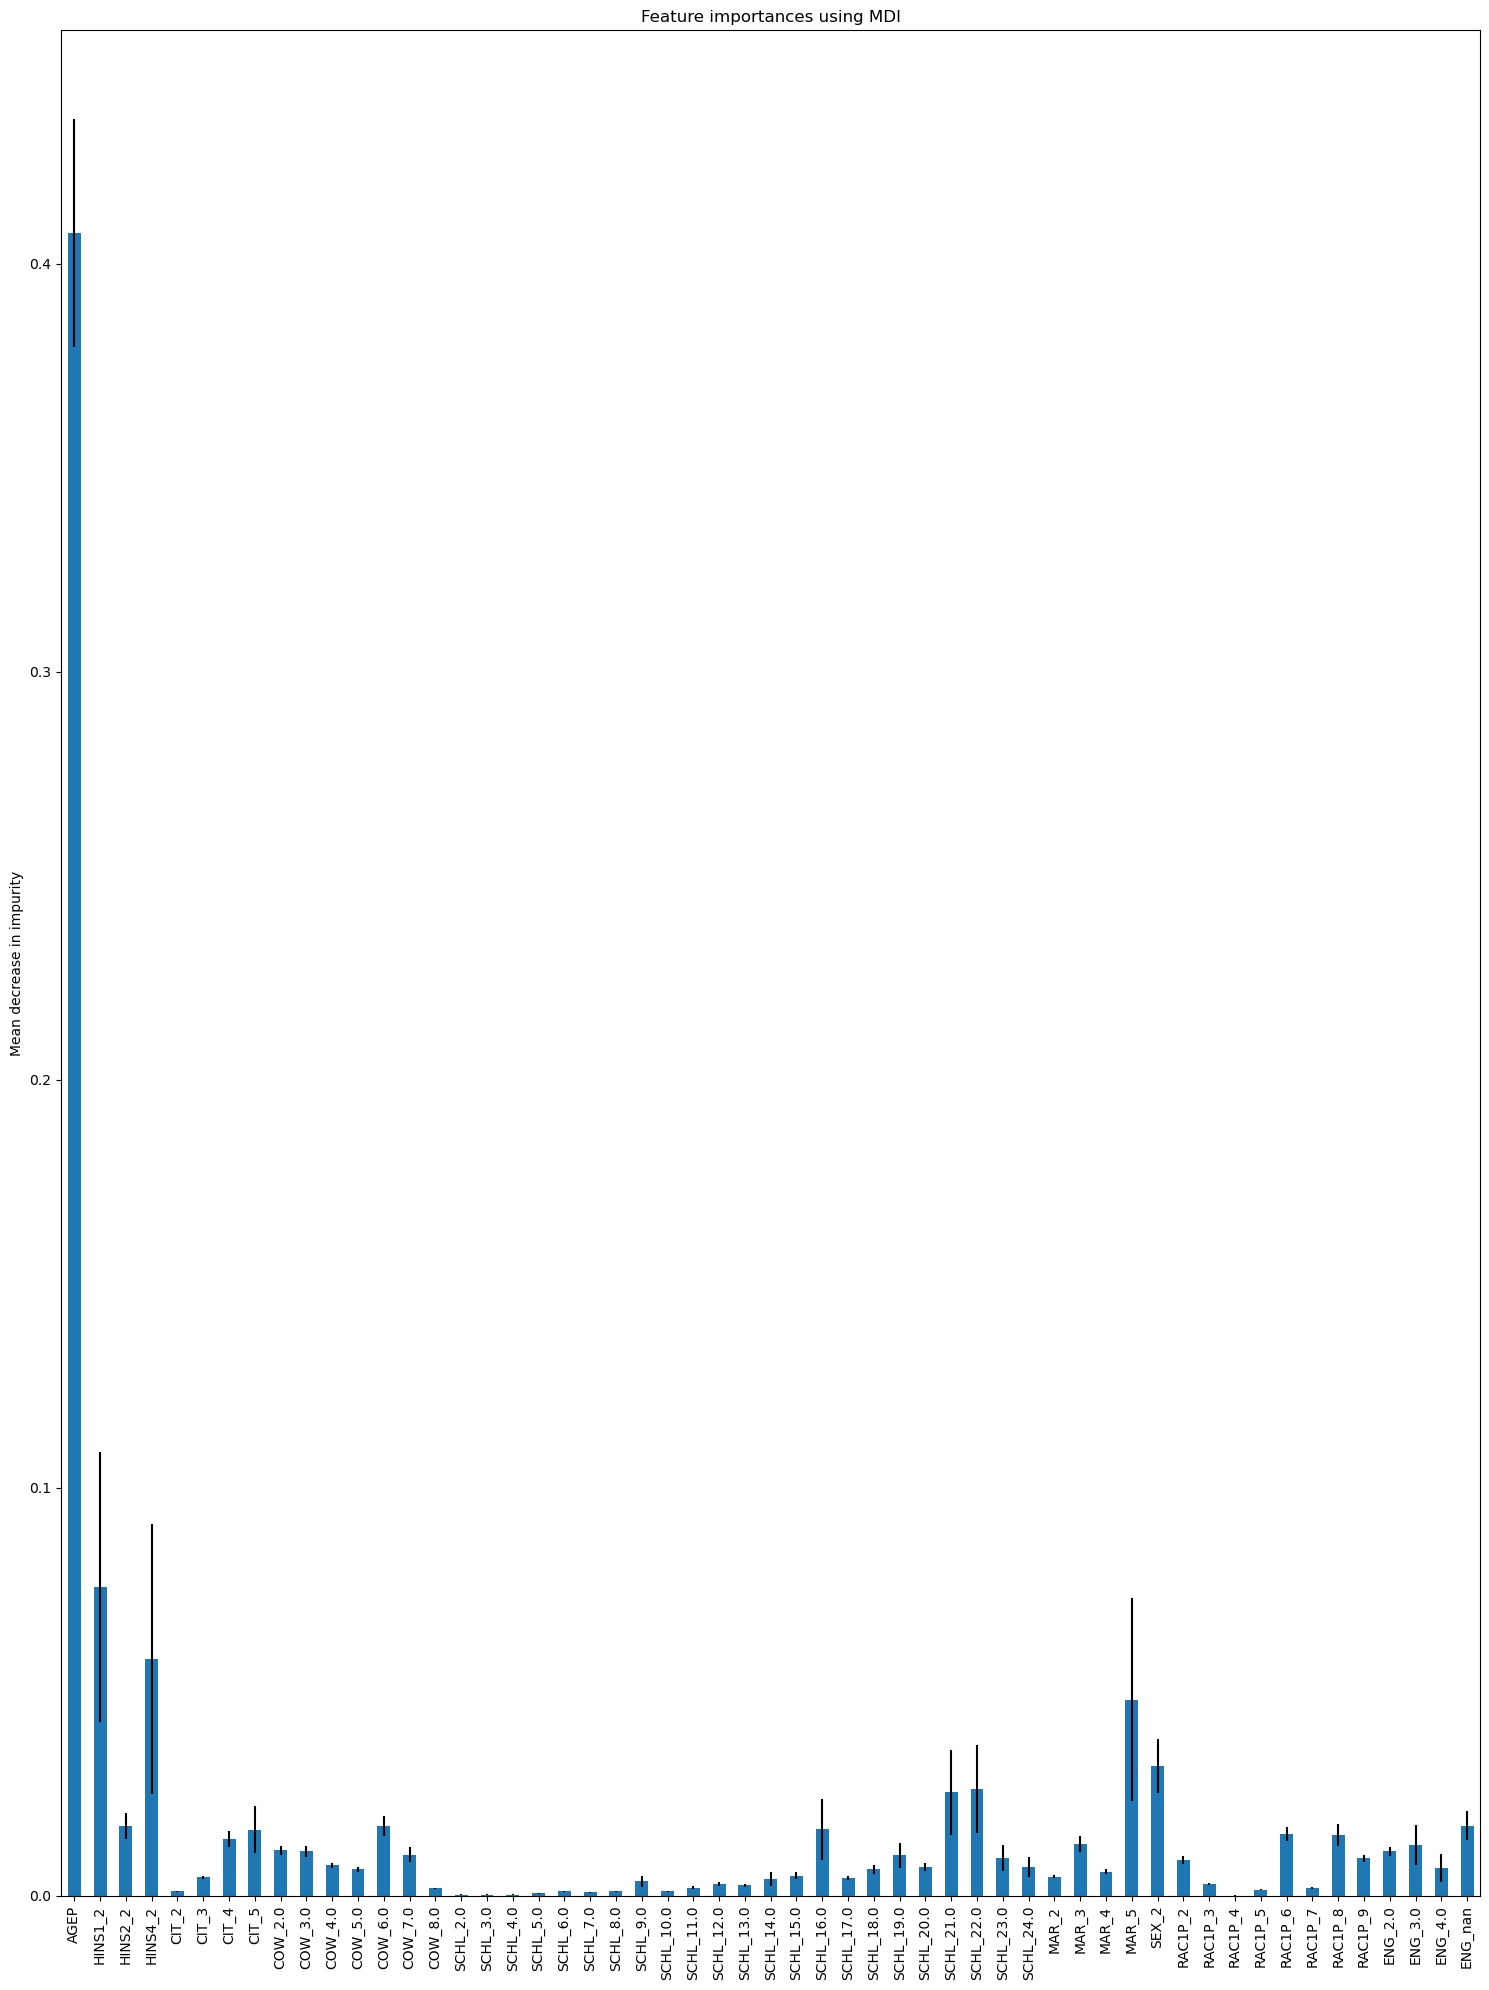

In [20]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()